# Machine Learning: Perceptron Algorithm

Submitted by Mary Franczine Tan

Applied Physics 157

AY 2022-2023 2nd Semester

The objective for this activity is to train a perceptron model to distinguish between apples and bananas.

In [1]:
# import packages

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.measure import regionprops, label, regionprops_table
from skimage.util import img_as_ubyte

## Data Preparation

For the data preparation, I used `glob` to store the filenames in a list. Then I've created two functions that will conduct the image processing.

The function `processImage` conducts image thresholding and returns the mask as well as the segmented image. Meanwhile, `getFeatures` will read the image, call on `processImage`, and conduct feature extraction.

The features we are interested in getting here are the __eccentricity__ and the __green-ness__ of the image. Eccentricitty describes how circular a shape is. For our case, apples have lower eccentricity because they are more circular, while bananas have higher eccentricity because they are longer. Green-ness, we define, as the average value of the image in its green channel. Bananas are expected to have higher green-ness, since their color yellow is a combination of active red and green channels. Apples, on the other hand, will have lower green-ness because they are mostly color red.

All of these data is stored in the dataframe `train`.

In [2]:
# extract filenames 

apple_filenames = sorted(glob.glob('train/freshapples/*.png'))
banana_filenames = sorted(glob.glob('train/freshbanana/*.png'))

In [3]:
# segment image

def processImage(img):
    """
        performs thresholding and masking on an image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert image to grayscale
    gray[np.where(gray < 50)] = gray.max() # turn black background portions to white
    
    blur = cv2.GaussianBlur(gray, (5, 5), 0) # apply gaussian blur to image
    ret, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # segment using otsu's method
    
    th2 = cv2.bitwise_not(th) # invert threshold 
    thresh1d = cv2.erode(th2, np.ones((10,10), np.uint8)) # erode threshold
    
    _, _, layers = img.shape # get number of img channels
    
    if layers == 3: # if image has 3 channels
        thresh = cv2.merge((thresh1d, thresh1d, thresh1d)) # create 3-layer threshold for masking
    elif layers == 4: # if image has 4 channels
        thresh = cv2.merge((thresh1d, thresh1d, thresh1d, thresh1d)) # create 4-layer threshold for masking
        
    masked = cv2.bitwise_and(img, thresh) # mask image
    
    
    return masked, thresh1d

In [4]:
# extract image features

def getFeatures(file):
    """
        reads image, perform pre-processing, and get its features
    """
    
    orig = img_as_ubyte(plt.imread(file)) # read image as uint8 type
    img, bnw = processImage(orig) # segment image
    
    labeled = label(bnw) # label regions
    props = regionprops_table(labeled, properties = ('label', 'area', 'eccentricity')) # get region properties table
    props_df = pd.DataFrame(props) # turn table to dataframe
    
    # get the eccentricity
    
    max_index = props_df.idxmax(axis = 0) # retrieve index with max values per column
    index = max_index['area'] # get index for max area
    eccentricity = props_df.iloc[index]['eccentricity']
    #print(eccentricity)
       
    # get the average green value
    
    green_layer = img[...,1]
    green_nozeroes = green_layer[np.nonzero(green_layer)]
    green = np.mean(green_nozeroes)
    #print(green)
    
    return eccentricity, green

In [5]:
# create dataframe of the training data

train_features = [] # create empty list

for file in apple_filenames: # append apples data to list
    fruit = 'apple' # set type of fruit
    target = 1 # set target value
    eccentricity, green = getFeatures(file) # set feature values
    train_features.append([fruit, eccentricity, green, target]) # append to list
    
for file in banana_filenames:
    fruit = 'banana' # set type of fruit
    target = -1 # set target valye
    eccentricity, green = getFeatures(file) # set feature values
    train_features.append([fruit, eccentricity, green, target]) # append to list
    
train = pd.DataFrame(train_features, columns = ['fruit', 'x1', 'x2', 'y']) # create dataframe
train.x2 = train.x2 / train.x2.max() # normalize x2
display(train.head()) # show head of dataframe 

,fruit,x1,x2,y
0,apple,0.515150,0.254916,1
1,apple,0.262903,0.225285,1
2,apple,0.258596,0.314737,1
3,apple,0.747035,0.446362,1
4,apple,0.542761,0.285845,1


## Model Training

A perceptron works by combing input features and their corresponding weights to get the weighted sum $a$ of its features. This weighted sum is passed on to a thresholding function to determine how it is classified. Here, we use the step function

$$ z =  \begin{cases} 
      1 & a \geq 0 \\
      -1 & a < 0 
   \end{cases}
$$

We start with arbitary values for the weights of each feature. As we iterate over each set of input features, the weights are updated by the equation

$$
    w_j = w_j + \Delta w_j
$$

where

$$
    \Delta w_j = \eta (d^i - z^i)x^i_j
$$

We call one weight change iteration over the entire dataset an __epoch__. And we perform as many epochs as we want until the error of the model has reached a desirable value.

In [6]:
# include constant bias input
train['x0'] = 1 

# set initial weights
weights = [0.4, 0.4, 0.4] # w0, w1, w2

# set learning rate
n = 0.1

# reorder dataframe
train = train[['fruit', 'x0', 'x1', 'x2', 'y']]

In [7]:
def getW_sum(feature, weights):
    return np.dot(feature, weights)

In [8]:
def step_function(weighted_sum):
    
    threshold = 0
    
    if weighted_sum > threshold:
        return 1
    else:
        return -1

In [9]:
def updateWeight(feature, weights, target, prediction):
    
    new_weights = []
    for x, w in zip(feature, weights):
        new_w = w + n * (target - prediction) * x
        new_weights.append(new_w)
        
    return new_weights

In [10]:
# create list for errors per epoch
epoch_errors = []

def train_model(df, weights, epochs):
    
    for e in range(epochs + 1):
        error_count = 0
        
        for i in range(len(df)):
            feature = df.loc[i][1:4]
            target = df.loc[i][4]
            w_sum = getW_sum(feature, weights)
            prediction = step_function(w_sum)
            
            if prediction != target:
                error_count += 1
            
            weights = updateWeight(feature, weights, target, prediction)
        
        error_percent = error_count / len(df) * 100
        epoch_errors.append(error_percent)
    
    return weights

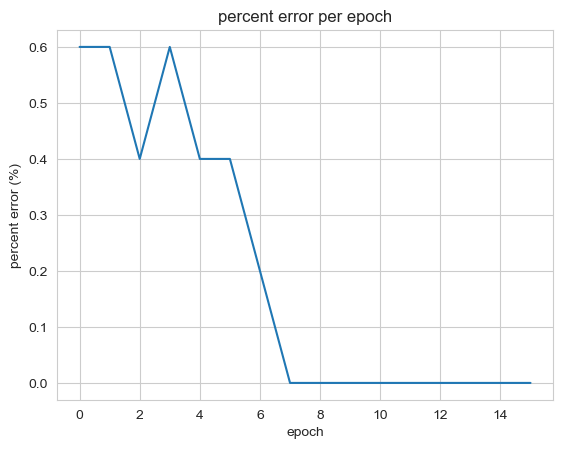

In [11]:
epoch_errors = []

# train model, get new weights
new_weights = train_model(train, weights, 15)

# plot errors per epoch 
sns.set_style('whitegrid')
plt.plot(epoch_errors)
plt.xlabel('epoch')
plt.ylabel('percent error (%)')
plt.title('percent error per epoch')
plt.savefig('perceptron_images/epochErrors')

The decision line is the boundary between the two classifications, and it is determined by the final values of our weights, given by the equation

$$
    w_1 + w_2 x_2 + w_3 x_3 = T
$$

where $T$ is the threshold, in our case zero.

After that, we can now compute the final predictions using the final values of the weighted sum.

In [12]:
def decisionLine(x, weights):
    """
        returns the y for each x in the decision line
    """
    
    slope = - weights[1] / weights[2]
    intercept = - weights[0] / weights[2]

    return intercept + slope * x

x = np.linspace(0, 1, 10)
y = decisionLine(x, new_weights)

In [13]:
# get weighted sum using trained weights
train['w_sum'] = getW_sum(train[['x0', 'x1', 'x2']], new_weights)

# get prediction of fruit
train['y_hat'] = [step_function(w) for w in train['w_sum']]

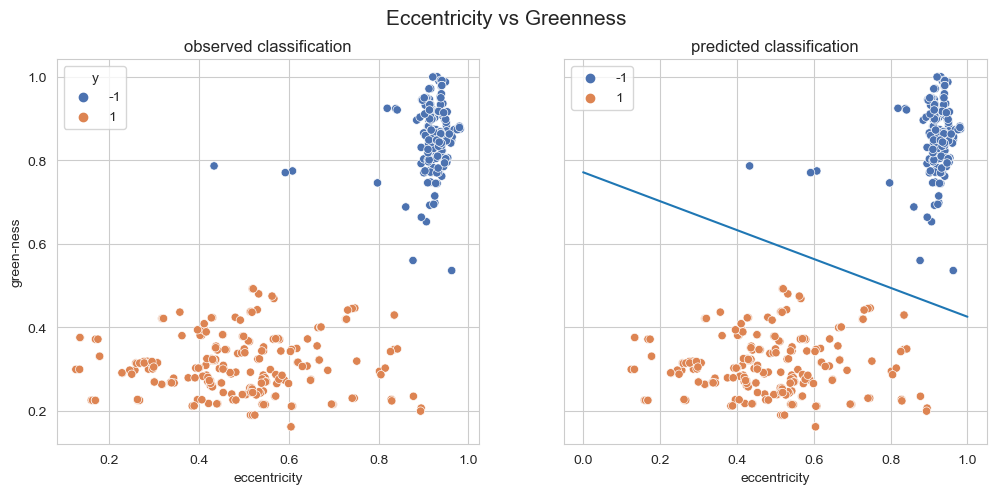

In [24]:
# plot the observed and predicted classification

fig, ax = plt.subplots(1, 2, figsize = (12, 5), sharey = True)

sns.scatterplot(ax = ax[0], data = train, x = 'x1', y = 'x2', hue = 'y', palette = 'deep') # observed
sns.scatterplot(ax=ax[1], data = train, x = 'x1', y = 'x2', hue = 'y_hat', palette = 'deep') # predicted
sns.lineplot(ax = ax[1], x = x, y = y) # decision line
ax[0].set_title('observed classification')
ax[1].set_title('predicted classification')
ax[0].set_xlabel('eccentricity')
ax[0].set_ylabel('green-ness')
ax[1].set_xlabel('eccentricity')
ax[1].set_ylabel('green-ness')
plt.suptitle('Eccentricity vs Greenness', size = 15)
plt.savefig('perceptron_images/trainPlot')

As we can see above, the data clump together by classification. __The model has succesfully separated these two classifications using the decision line__.

We can also find the confusion matrix, which is shown as

|     | 1 (predicted) | -1 (predicted) |
| --- | --- | --- |
| 1 (observed) | True Positive (TP) | False Negative (FN) |
| -1 (observed) | False Positive (FP) | True Negative (TN) |

and calculate the model's accuracy using the equation

$$
    \text{accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP + TN + FP + FN}}
$$

We see that the training model has an accuracy of 1.0, which means a perfect accuracy.

In [15]:
def confusionMatrix(data):
    
    tp = len(data[(data['y'] == 1) & (data['y_hat'] == 1)])
    tn = len(data[(data['y'] == -1) & (data['y_hat'] == -1)])
    fp = len(data[(data['y'] == -1) & (data['y_hat'] == 1)])
    fn = len(data[(data['y'] == 1) & (data['y_hat'] == -1)])
    
    print('true positive: ' + str(tp))
    print('true negative: ' + str(tn))
    print('false positive: ' + str(fp))
    print('false negative: ' + str(fn))
    print('accuracy: ' + str((tp + tn) / len(data)))

In [16]:
# get error percentage of training data
error_train = len(train[train.y != train.y_hat]) / len(train) * 100

print('training - confusion matrix')
confusionMatrix(train)

training - confusion matrix
true positive: 250
true negative: 250
false positive: 0
false negative: 0
accuracy: 1.0


## Model Testing

In testing, we use the values of the weights and the decision line to try and classify fruits on images that the model hasn't seen before. We do the same method image of image pre-processing as the training set, and also compute its confusion matrix to get the model's accuracy with the testing data set.

We can see that the model still has an accuracy of 1.0 in the testing dataset.

In [17]:
apple_test = sorted(glob.glob('test/freshapples/*.png'))
banana_test = sorted(glob.glob('test/freshbanana/*.png'))

In [18]:
# create dataframe of the testing data

test_features = [] # create empty list

for file in apple_test: # append apples data to list
    fruit = 'apple' # set type of fruit
    target = 1 # set target value
    eccentricity, green = getFeatures(file) # set feature values
    test_features.append([fruit, eccentricity, green, target]) # append to list
    
for file in banana_test:
    fruit = 'banana' # set type of fruit
    target = -1 # set target valye
    eccentricity, green = getFeatures(file) # set feature values
    test_features.append([fruit, eccentricity, green, target]) # append to list
    
test = pd.DataFrame(test_features, columns = ['fruit', 'x1', 'x2', 'y']) # create dataframe
test.x2 = test.x2 / test.x2.max() # normalize x2


test['x0'] = 1 # include constant bias input
test = test[['fruit', 'x0', 'x1', 'x2', 'y']] # reorder dataframe

In [19]:
# get weighted sum using trained weights
test['w_sum'] = getW_sum(test[['x0', 'x1', 'x2']], new_weights)

# get prediction of fruit
test['y_hat'] = [step_function(w) for w in test['w_sum']]

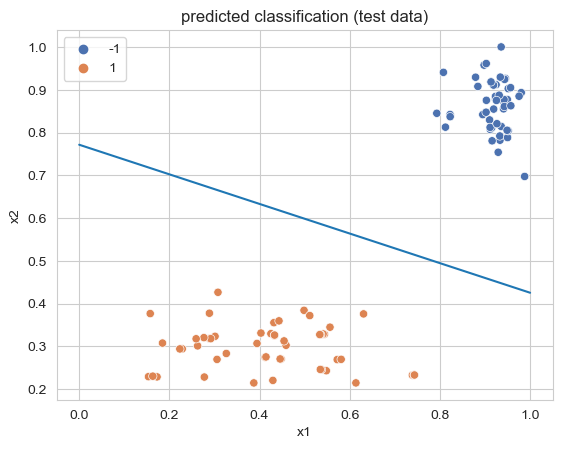

In [20]:
# plot classification
sns.scatterplot(data = test, x = 'x1', y = 'x2', hue = 'y_hat', palette = 'deep')
sns.lineplot(x = x, y = y) # decision line
plt.title('predicted classification (test data)')
plt.savefig('perceptron_images/testPlot')

In [21]:
print('testing - confusion matrix')
confusionMatrix(test)

testing - confusion matrix
true positive: 50
true negative: 50
false positive: 0
false negative: 0
accuracy: 1.0


## sources

- image data type conversion from [scikit-learn documentation](https://scikit-image.org/docs/stable/user_guide/data_types.html)
- perceptron algorithm from Python Simplified [youtube tutorial](https://www.youtube.com/watch?v=-KLnurhX-Pg)
- weight change algorithm from Python Simplified [youtube tutorial](https://www.youtube.com/watch?v=aOEoxyA4uXU)
- accuracy and confusion matrix from [HackerEarth](https://www.hackerearth.com/practice/machine-learning/machine-learning-algorithms/logistic-regression-analysis-r/tutorial/#:~:text=The%20formula%20to%20calculate%20the,values%2C%20have%20been%20incorrectly%20predicted.)